# 02_train_mitofomer_model.ipynb
## Train Mitofomer on simulated DNA plus multi-omics features
### Compact transformer in PyTorch when available, otherwise a scikit learn fallback

Train shapes, tokens (8000, 300) omics (8000, 50) targets (8000, 3)
Test shapes,  tokens (2000, 300) omics (2000, 50) targets (2000, 3)
Epoch 001, train loss 12160.2557, val loss 1284.5067, R2 ATP -3.047, R2 ROS -20.477, R2 OCR -26.070
Epoch 002, train loss 552.0688, val loss 276.2277, R2 ATP 0.194, R2 ROS -1.548, R2 OCR -5.064
Epoch 003, train loss 285.3635, val loss 200.4305, R2 ATP 0.286, R2 ROS -0.977, R2 OCR -2.978
Epoch 004, train loss 221.6817, val loss 159.8970, R2 ATP 0.282, R2 ROS -0.513, R2 OCR -1.693
Epoch 005, train loss 185.2476, val loss 132.8225, R2 ATP 0.388, R2 ROS -0.487, R2 OCR -1.182
Epoch 006, train loss 157.1281, val loss 112.4522, R2 ATP 0.474, R2 ROS -0.539, R2 OCR -0.817
Epoch 007, train loss 134.7879, val loss 93.0171, R2 ATP 0.608, R2 ROS -0.295, R2 OCR -0.642
Epoch 008, train loss 119.6783, val loss 72.1427, R2 ATP 0.728, R2 ROS -0.110, R2 OCR -0.376
Epoch 009, train loss 102.5421, val loss 58.7730, R2 ATP 0.796, R2 ROS 0.012, R2 OCR -0.178
Epoch 010, train

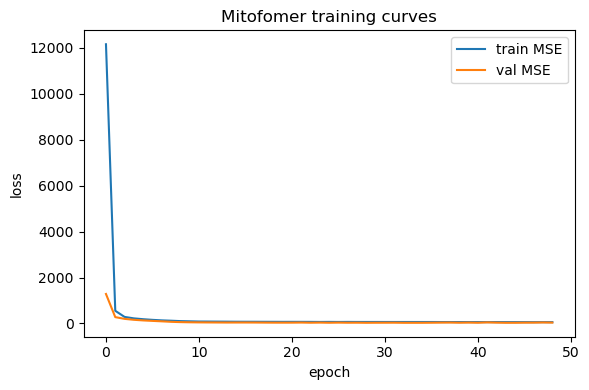

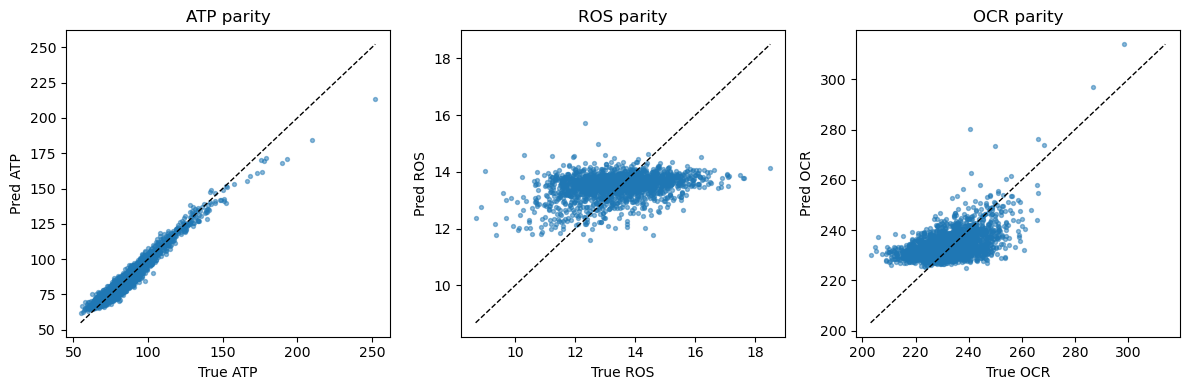

Done, model training complete, artifacts saved in results


In [3]:
import os
import json
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

DATA_FILE = Path("data") / "mitofomer_training_table.csv"
assert DATA_FILE.exists(), "Cannot find data, run 01_generate_synthetic_datasets.ipynb first"

df = pd.read_csv(DATA_FILE)

# Prepare inputs and targets
# Targets
y_cols = ["ATP_production", "ROS_accumulation", "OCR_efficiency"]
Y = df[y_cols].values.astype(np.float32)

# Omics features, keep all engineered features created in Step 1
omics_cols = [c for c in df.columns if c.startswith("feat_")]
X_omics = df[omics_cols].values.astype(np.float32)

# DNA sequences
seqs = df["dna_seq"].astype(str).tolist()

# Train test split by design id, stratify by condition for a mild balance
train_idx, test_idx = train_test_split(
    np.arange(len(df)),
    test_size=0.2,
    random_state=SEED,
    stratify=df["condition"]
)

# Convenience splits
Y_train, Y_test = Y[train_idx], Y[test_idx]
Xo_train, Xo_test = X_omics[train_idx], X_omics[test_idx]
seq_train = [seqs[i] for i in train_idx]
seq_test  = [seqs[i] for i in test_idx]

# DNA tokenization with k mers and hashing to a fixed vocab
K = 6
VOCAB = {"A":0, "C":1, "G":2, "T":3}

def kmer_hash_index(kmer, buckets=4096):
    h = 0
    for ch in kmer:
        h = (h * 131 + ord(ch)) & 0xFFFFFFFF
    return h % buckets

def seq_to_token_ids(seq, k=K, buckets=4096, max_len=300):
    toks = []
    for i in range(len(seq) - k + 1):
        km = seq[i:i+k]
        toks.append(kmer_hash_index(km, buckets))
        if len(toks) >= max_len:
            break
    # pad to max_len
    if len(toks) < max_len:
        toks += [0] * (max_len - len(toks))
    return np.array(toks, dtype=np.int64)

MAX_TOK_LEN = 300        # 300 minus k plus one is near 295 for len 300, small pad
VOCAB_SIZE  = 4096       # hashed k mer space

Xt_train = np.stack([seq_to_token_ids(s, k=K, buckets=VOCAB_SIZE, max_len=MAX_TOK_LEN) for s in seq_train])
Xt_test  = np.stack([seq_to_token_ids(s, k=K, buckets=VOCAB_SIZE, max_len=MAX_TOK_LEN) for s in seq_test])

print("Train shapes, tokens", Xt_train.shape, "omics", Xo_train.shape, "targets", Y_train.shape)
print("Test shapes,  tokens", Xt_test.shape,  "omics", Xo_test.shape,  "targets", Y_test.shape)

# Try PyTorch first, otherwise fall back to scikit learn

use_torch = False
try:
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader
    use_torch = True
except Exception as e:
    print("PyTorch not available, falling back to a scikit learn baseline")
    use_torch = False

# PyTorch path, compact transformer encoder for sequence, MLP for omics

if use_torch:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(SEED)

    class MitoDataset(Dataset):
        def __init__(self, toks, omics, targets):
            self.toks = torch.from_numpy(toks).long()
            self.omics = torch.from_numpy(omics).float()
            self.targets = torch.from_numpy(targets).float()
        def __len__(self):
            return self.toks.shape[0]
        def __getitem__(self, idx):
            return self.toks[idx], self.omics[idx], self.targets[idx]

    train_ds = MitoDataset(Xt_train, Xo_train, Y_train)
    test_ds  = MitoDataset(Xt_test,  Xo_test,  Y_test)

    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, drop_last=False)
    test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, drop_last=False)

    class Mitofomer(nn.Module):
        def __init__(self, vocab_size, emb_dim=128, n_layers=2, n_heads=4, ff_dim=256, omics_dim=None):
            super().__init__()
            self.emb = nn.Embedding(vocab_size, emb_dim)
            enc_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=0.1, batch_first=True)
            self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
            self.seq_pool = nn.AdaptiveAvgPool1d(1)
            self.omics_mlp = nn.Sequential(
                nn.Linear(omics_dim, 128),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(128, 128),
                nn.ReLU()
            )
            self.head = nn.Sequential(
                nn.Linear(emb_dim + 128, 128),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(128, 3)
            )
            # init
            nn.init.normal_(self.emb.weight, mean=0.0, std=0.02)

        def forward(self, toks, omics):
            x = self.emb(toks)                   # B, L, E
            x = self.encoder(x)                  # B, L, E
            x = x.transpose(1, 2)                # B, E, L
            x = self.seq_pool(x).squeeze(-1)     # B, E
            o = self.omics_mlp(omics)            # B, 128
            z = torch.cat([x, o], dim=1)         # B, E plus 128
            out = self.head(z)                   # B, 3
            return out

    model = Mitofomer(vocab_size=VOCAB_SIZE, emb_dim=128, n_layers=2, n_heads=4, ff_dim=256, omics_dim=Xo_train.shape[1]).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = nn.MSELoss()

    def eval_metrics(model, loader):
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for toks, omics, target in loader:
                toks = toks.to(device)
                omics = omics.to(device)
                target = target.to(device)
                out = model(toks, omics)
                preds.append(out.cpu().numpy())
                trues.append(target.cpu().numpy())
        P = np.vstack(preds)
        T = np.vstack(trues)
        r2 = r2_score(T, P, multioutput="raw_values")
        mae = np.mean(np.abs(T - P), axis=0)
        return P, T, r2.tolist(), mae.tolist()

    # Training loop
    train_losses, val_losses = [], []
    best_val = np.inf
    patience, wait = 15, 0
    EPOCHS = 60

    for epoch in range(1, EPOCHS+1):
        model.train()
        running = 0.0
        for toks, omics, target in train_loader:
            toks = toks.to(device)
            omics = omics.to(device)
            target = target.to(device)
            opt.zero_grad()
            out = model(toks, omics)
            loss = loss_fn(out, target)
            loss.backward()
            opt.step()
            running += loss.item() * toks.size(0)
        train_loss = running / len(train_ds)

        # validation
        P_val, T_val, r2_val, mae_val = eval_metrics(model, test_loader)
        val_loss = np.mean((P_val - T_val) ** 2)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch:03d}, train loss {train_loss:.4f}, val loss {val_loss:.4f}, "
              f"R2 ATP {r2_val[0]:.3f}, R2 ROS {r2_val[1]:.3f}, R2 OCR {r2_val[2]:.3f}")

        # early stop
        if val_loss < best_val - 1e-4:
            best_val = val_loss
            wait = 0
            torch.save(model.state_dict(), RESULTS_DIR / "mitofomer_torch.pt")
        else:
            wait += 1
            if wait >= patience:
                print("Early stop, best val loss", best_val)
                break

    # Load best model and compute final metrics
    model.load_state_dict(torch.load(RESULTS_DIR / "mitofomer_torch.pt", map_location=device))
    P_test, T_test, r2_final, mae_final = eval_metrics(model, test_loader)

    metrics = {
        "framework": "pytorch",
        "r2_ATP": r2_final[0],
        "r2_ROS": r2_final[1],
        "r2_OCR": r2_final[2],
        "mae_ATP": mae_final[0],
        "mae_ROS": mae_final[1],
        "mae_OCR": mae_final[2],
        "val_mse": float(np.mean((P_test - T_test) ** 2))
    }

else:

    # scikit learn fallback, multi output regression
    # Use hashed k mer bag features plus omics features
    from sklearn.ensemble import RandomForestRegressor

    # Build bag of k mer hashed counts with fixed length representation
    def bag_of_kmers(seqs, k=K, buckets=1024):
        B = np.zeros((len(seqs), buckets), dtype=np.float32)
        for i, s in enumerate(seqs):
            for j in range(len(s) - k + 1):
                km = s[j:j+k]
                idx = kmer_hash_index(km, buckets=buckets)
                B[i, idx] += 1.0
        # normalize by length
        B = B / B.sum(axis=1, keepdims=True)
        B[np.isnan(B)] = 0.0
        return B

    Xb_train = bag_of_kmers(seq_train, buckets=1024)
    Xb_test  = bag_of_kmers(seq_test,  buckets=1024)

    X_train = np.hstack([Xb_train, Xo_train])
    X_test  = np.hstack([Xb_test,  Xo_test])

    rf = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        random_state=SEED,
        n_jobs=-1
    )
    rf.fit(X_train, Y_train)
    P_test = rf.predict(X_test)

    r2v = r2_score(Y_test, P_test, multioutput="raw_values")
    mae = np.mean(np.abs(Y_test - P_test), axis=0)

    metrics = {
        "framework": "sklearn_random_forest",
        "r2_ATP": float(r2v[0]),
        "r2_ROS": float(r2v[1]),
        "r2_OCR": float(r2v[2]),
        "mae_ATP": float(mae[0]),
        "mae_ROS": float(mae[1]),
        "mae_OCR": float(mae[2]),
        "val_mse": float(np.mean((P_test - Y_test) ** 2))
    }

    # save baseline model
    import joblib
    joblib.dump(rf, RESULTS_DIR / "mitofomer_rf.joblib")

# Save metrics and quick plots
with open(RESULTS_DIR / "training_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved metrics", json.dumps(metrics, indent=2))

# Learning curves for torch path
if use_torch:
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label="train MSE")
    plt.plot(val_losses, label="val MSE")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Mitofomer training curves")
    plt.legend()
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "training_curves.png", bbox_inches="tight")
    plt.show()

# Parity plots for test set
labels = ["ATP", "ROS", "OCR"]
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.scatter(T_test[:,i], P_test[:,i], s=8, alpha=0.5)
    lims = [
        min(T_test[:,i].min(), P_test[:,i].min()),
        max(T_test[:,i].max(), P_test[:,i].max())
    ]
    plt.plot(lims, lims, "k--", lw=1)
    plt.xlabel(f"True {labels[i]}")
    plt.ylabel(f"Pred {labels[i]}")
    plt.title(f"{labels[i]} parity")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "parity_plots.png", bbox_inches="tight")
plt.show()

print("Done, model training complete, artifacts saved in", str(RESULTS_DIR))